# A Neural Algorithm of Artistic Style
This is an implementation of ["A Neural Algorithm of Artistic Style"](https://arxiv.org/abs/1508.06576) written by Leon A. Gatys, Alexander S. Ecker, and Mattias Bethge. \\
![alt text](https://farm5.staticflickr.com/4626/39836451444_f322b9a6fc_b.jpg)

In [0]:
# https://keras.io/
!pip install -q keras
import keras

In [0]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.callbacks import TensorBoard
from time import time
import matplotlib.pyplot as plt
import scipy.io

from skimage.io import imread, imsave
import scipy.misc

%matplotlib inline


In [0]:
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]



## Import Model Weights and Images
In order to quickly import the model weights, upload weights into a Google Cloud Platform Storage bucket and replace 'project-id' with the ID of your project and 'model_weights' with the name of your storage bucket.

In [56]:
from google.colab import auth
auth.authenticate_user()

project_id = 'neural-style-transfer-196700'
!gcloud config set project {project_id}

# Download the file.
!gsutil cp gs://model_weights/imagenet-vgg-verydeep-19.mat vgg19.mat

Updated property [core/project].
Copying gs://model_weights/imagenet-vgg-verydeep-19.mat...
- [1 files][510.1 MiB/510.1 MiB]                                                
Operation completed over 1 objects/510.1 MiB.                                    


In [0]:
def normalize_image(image):
  """
  Normalizes image by subtracting mean values
  
  Arguments:
    image (ndarray) = input image
      dimensions: (1,224,224,3)
      
  Returned:
    image (ndarray) = normalized image
      dimensions: (1,224,224,3)
  """
  normalized = np.array(image) - MEAN_VALUES
  return normalized

In [1]:
#Google Colab image input

from google.colab import files
import io
from PIL import Image

print("Upload a Style Image:")
style = files.upload()
print("Upload a Content Image")
content = files.upload()

for fn in style.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(style[fn])))
for fn in content.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
    name=fn, length=len(content[fn])))

style_image = Image.open(io.BytesIO(style[list(style.keys())[0]]))
content_image = Image.open(io.BytesIO(content[list(content.keys())[0]]))

style_image = scipy.misc.imresize(style_image, (224,224,3))
content_image = scipy.misc.imresize(content_image, (224,224,3))

style_image = np.reshape(style_image, [1,224,224,3])
content_image = np.reshape(content_image, [1,224,224,3])

style_image = normalize_image(style_image)
content_image = normalize_image(content_image)


Upload a Style Image:


Upload a Content Image


IndexError: ignored

In [0]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, 224, 224, 3)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph


In [0]:
def display_image(image, title=''):
  """
  Displays a given image using matplotlib.pyplot
  
  Arguments:
    image (ndarray) = numpy array of an image
      dimensions: (1,224,224,3)
    title (string) = title for the displayed image
    
  """
  
  image = image[0] + MEAN_VALUES[0]
  
  image = np.clip(image, 0, 255).astype('uint8')
  plt.figure()
  plt.imshow(image)
  plt.title(title)
  plt.show()

## Computing Loss
* The **content loss** computes the difference between the content image activations and the generated image activations at a given layer of the network. 
* The **style loss** compares the correlation between feature maps of the style image and generated image at specified layers.
* The **total loss** is calculated by adding the weighted content loss and weighted style loss. The losses are weighted by parameters alpha and beta respectively.



In [0]:
def compute_content_loss(a_C, a_G):
    """
    Computes content loss from a single layer.
    
    Arguments:
        a_C (Tensor) = activation from content image at specified hidden layer,
            Dimensions: (1, height, width, channel)
              
        a_G (Tensor) = activation from generated image at specified hidden layer,
            Dimensions: (1, height, width, channel)
        
    Return:
        Content Loss (float32) = squared error * regularization
    """
    
    m, n_h, n_w, n_c = a_C.get_shape().as_list()
    reg = 1 / (4 * n_h * n_w * n_c)
    
    c_loss = reg * tf.reduce_sum(tf.square(a_C - a_G))
    return c_loss
  


In [0]:
  
def gram_matrix(A):
    """
    Computes gram matrix
    
    Arguments:
        A (Tensor) = matrix to apply gram matrix to,
            finds correlation between channel activations.
            Dimensions: (n_h, n_w, n_c)
        
    Return:
        Gram Matrix (Tensor) = A*A.transpose
            Dimensions: (n_C, n_C)
    """
    
    n_h, n_w, n_c = A.get_shape().as_list()
    
    A = tf.reshape(A, (n_c, n_w * n_h))
    
    return tf.matmul(A, tf.transpose(A))


def compute_style_loss(a_S, a_G):
    """
    Computes style loss from a single layer.
    
    Arguments:
        a_S (Tensor) = activation from tcontentimage at specified hidden layer,
            Dimensions: (1, height, width, channel)
              
        a_G (Tensor) = activation from generated image at specified hidden layer,
            Dimensions: (1, height, width, channel)
        
    Return:
        Style Loss (float32) = squared error * regularization
    """
    
    assert a_S.shape == a_G.shape
    m, n_h, n_w, n_c = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, (n_h, n_w, n_c))
    a_G = tf.reshape(a_G, (n_h, n_w, n_c))

    gram_S = gram_matrix(a_S)
    gram_G = gram_matrix(a_G)

    squared_error = tf.reduce_sum(tf.square(gram_S - gram_G))
    reg = pow(2 * n_h * n_w * n_c, 2)

      
    return (1/reg) * squared_error

In [0]:
def multi_layer_style_loss(sess, model, STYLE_LAYERS):
    """
    """
    total_style_loss = 0
    for layer, weight in STYLE_LAYERS:
        output = model[layer]
        a_S = sess.run(output)
        a_G = output
        layer_loss = compute_style_loss(a_S, a_G)
        total_style_loss += layer_loss * weight

    return total_style_loss

In [0]:
def compute_total_loss(content_loss, style_loss, alpha=10, beta=40):
    """
    Computes total loss of content and style
    
    Arguments:
      content_loss (float)
      style_loss (float)
      
      Optional:
        alpha (int) = content weight
        beta (int) = style weight
        
    Returned:
      total loss (int)
    """
    loss = alpha * content_loss  + beta * style_loss
    return loss

## Build Tensorflow Graph

In [0]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
# Load Model
model = load_vgg_model('vgg19.mat')

In [0]:
# Compute Content Loss
content_image = content_image.astype('float32')
sess.run(model['input'].assign(content_image))
output = model['conv3_1']
a_C = tf.convert_to_tensor(sess.run(output))
a_G = output

content_loss = compute_content_loss(a_C, a_G)

# Compute Style Loss
sess.run(model['input'].assign(style_image))
style_loss = multi_layer_style_loss(sess, model, STYLE_LAYERS)

In [0]:
# Generate input image by combining a random noise image with content image
generated_array = np.random.uniform(-20, 20, (1, 224, 224, 3)).astype('float32')
generated_img = generated_array * 0.6 + content_image * 0.4

In [0]:
# Calculate total loss and setup optimiation
loss = compute_total_loss(content_loss, style_loss, alpha = 1, beta = 1000)
optimizer = tf.train.AdamOptimizer(10)
train_step = optimizer.minimize(loss)

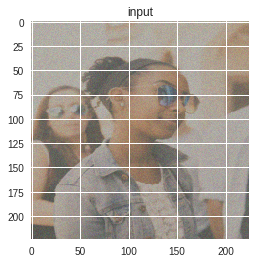

Iteration 10 :
total cost = 19189885000.0
content cost = 13319.975
style cost = 19189870.0


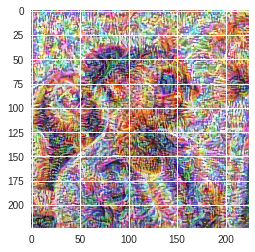

Iteration 20 :
total cost = 16590679000.0
content cost = 15605.546
style cost = 16590664.0


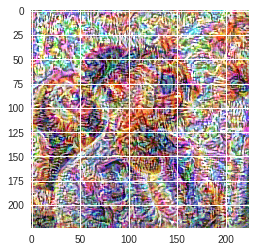

Iteration 30 :
total cost = 10545585000.0
content cost = 12882.712
style cost = 10545572.0


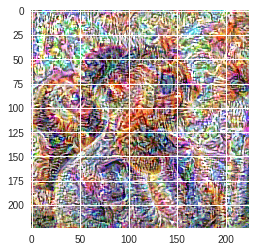

Iteration 40 :
total cost = 8782612000.0
content cost = 12035.14
style cost = 8782600.0


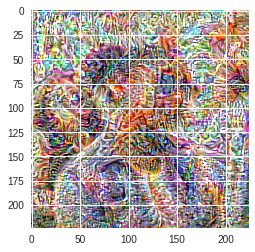

Iteration 50 :
total cost = 7763606500.0
content cost = 12704.316
style cost = 7763593.5


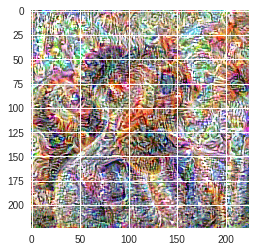

Iteration 60 :
total cost = 7121070000.0
content cost = 13505.4
style cost = 7121057.0


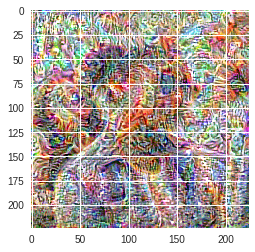

Iteration 70 :
total cost = 6639492600.0
content cost = 13633.092
style cost = 6639479.0


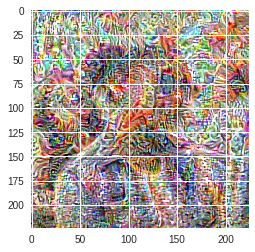

Iteration 80 :
total cost = 6245099500.0
content cost = 13674.31
style cost = 6245085.5


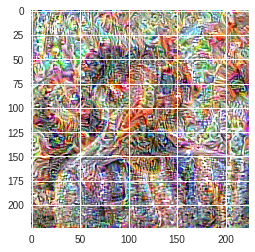

Iteration 90 :
total cost = 5900614700.0
content cost = 13854.918
style cost = 5900601.0


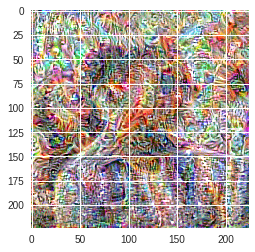

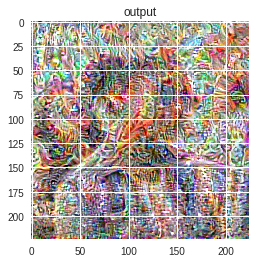

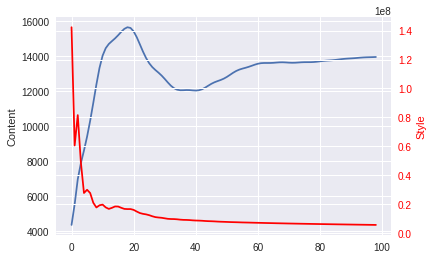

In [183]:
def style_transfer(sess, input_image, num_iterations=100, chart_interval = 10):
    """
    Run neural style transfer algorithm on the input image
    
    Arguments:
      sess = Tensorflow Session 
      input_image (ndarray) = generated image (content + noise)
        dimensions = (1, 224, 224, 3)
      num_iterations = number of iterations of style transfer
      chart_interval = frequency data for the chart is collected
    """
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))

    display_image(input_image, title='input')
    
    cost_data = [[],[],[]]
    
    for i in range(num_iterations):
        sess.run(train_step)

        
        # Track Style/Content Loss Data
        Jt, Jc, Js = sess.run([loss, content_loss, style_loss])
        if i > 0:
          cost_data[0].append(Jt)
          cost_data[1].append(Jc)
          cost_data[2].append(Js)
        
        
        if i % (num_iterations / 10) == 0 and i > 0:
          # Print out current cost
          print("Iteration " + str(i) + " :")
          print("total cost = " + str(Jt))
          print("content cost = " + str(Jc))
          print("style cost = " + str(Js))
          
          #Display current generated image
          gen_image = sess.run(model['input'])
          display_image(gen_image)
        
    fin_image = sess.run(model['input'])    

    display_image(fin_image, title='output')

    # Create Loss Chart
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(list(range(int(num_iterations)-1)), cost_data[1])
    ax1.set_ylabel('Content')

    ax2 = ax1.twinx()
    ax2.plot(list(range(int(num_iterations)-1)), cost_data[2], 'r-')
    ax2.set_ylabel('Style', color='r')
    for tl in ax2.get_yticklabels():          
      tl.set_color('r')
    fig.savefig('loss_chart.jpg')
    
    # Display and Save final image
    image = fin_image[0] + MEAN_VALUES[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave('generated.jpg', image)

    
style_transfer(sess, generated_img, chart_interval=10)

In [0]:
#Downloaded Generated Image
files.download('generated.jpg')

In [0]:
files.download('loss_chart.jpg')